# Detrend and Deseasonalize OISST

This notebook loads the OISST data then detrends and removes the seasonal cycle from the OISST data. The methods used on the whole dataset are checked on a subset of the globe over a 10-year span. Plotting on the entire globe is not contained in this notebook.

*Note: Used NPL 2025a kernel*

## Import Libraries

In [1]:
from dask.distributed import LocalCluster, Client
import glob
import matplotlib.pyplot as plt
import numpy as np
import warnings
import xarray as xr
warnings.filterwarnings('ignore')
xr.set_options(display_expand_data=False);

## Load the Data

In [2]:
# Spin up cluster
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:44521' processes=6 threads=36, memory=384.00 GiB>

In [3]:
# Read in data

# Get list of .nc files, excluding "preliminary" ones
file_list = glob.glob('/glade/campaign/univ/ucub0175/OISST/*.nc')
file_list = [file_name for file_name in file_list if "preliminary" not in file_name]

# Files in list are not in order by date
print(f"Path of first file in file_list: {file_list[0]}")

file_list_sorted = sorted(file_list)
print(f"Path of first file in sorted file_list: {file_list_sorted[0]}")

print(f"Found {len(file_list)} files")
# 15979 files without preliminary
# 15993 total files

Path of first file in file_list: /glade/campaign/univ/ucub0175/OISST/oisst-avhrr-v02r01.19911020.nc
Path of first file in sorted file_list: /glade/campaign/univ/ucub0175/OISST/oisst-avhrr-v02r01.19810901.nc
Found 15979 files


In [4]:
%%time
# Create SST xarray.Dataset (dask when specify chunks)
combined_sst = xr.open_mfdataset(
    file_list_sorted,
    concat_dim='time',
    combine='nested',
    parallel=True,           # use dask to load in parallel
    preprocess=lambda ds: ds[['sst']],  # only keep SST variable
    chunks={'lat': 120, 'lon': 240},  # break up by year
    engine='netcdf4'
)

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 240. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The 

CPU times: user 53.4 s, sys: 3.13 s, total: 56.5 s
Wall time: 1min 17s


In [5]:
combined_sst

<xarray.Dataset> Size: 66GB
Dimensions:  (time: 15979, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 128kB 1981-09-01T12:00:00 ... 2025-06-01T1...
  * zlev     (zlev) float32 4B 0.0
Data variables:
    sst      (time, zlev, lat, lon) float32 66GB dask.array<chunksize=(1, 1, 120, 240), meta=np.ndarray>
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

In [6]:
# Check time range
print(combined_sst['time'].values[0], combined_sst['time'].values[-1])
# 1981-09-01 to 2025-06-01

1981-09-01T12:00:00.000000000 2025-06-01T12:00:00.000000000


In [7]:
combined_sst['sst']

<xarray.DataArray 'sst' (time: 15979, zlev: 1, lat: 720, lon: 1440)> Size: 66GB
dask.array<chunksize=(1, 1, 120, 240), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 128kB 1981-09-01T12:00:00 ... 2025-06-01T1...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

In [8]:
print(combined_sst.time.dtype)  # datetime64[ns]

datetime64[ns]


## Detrend

First we create a function that takes a DataArray as input and detrends the SST time series. Then apply the detrend function to the OISST data.

In [9]:
def detrend_da(da):
    # Fit linear trend using xarray
    coeffs = da.polyfit(dim='time', deg=1)

    # Extract slope and intercept as DataArrays
    slope = coeffs.polyfit_coefficients.sel(degree=1)
    intercept = coeffs.polyfit_coefficients.sel(degree=0)

    # Convert time to numeric (float64), preserving Dask structure
    time_nums = (da['time'] - da['time'][0]) / np.timedelta64(1, 'D')  # days since first time point
    time_nums = time_nums.astype('float64')

    # Reshape time to broadcast automatically with slope/intercept (xarray handles this)
    trend = xr.apply_ufunc(
        lambda t, m, b: m * t + b,  # inputs & linear eq output
        time_nums,  # t = shape (time,)
        slope,      # m = shape (lat, lon)
        intercept,  # b = shape (lat, lon)
        input_core_dims=[['time'], [], []],  # t, m, b
        output_core_dims=[['time']],         # linear eq is time series
        # broadcast across all (lat, lon) in parallel
        vectorize=True,
        dask='parallelized',
        output_dtypes=[da.dtype]  # return (time, lat, lon) dataarray
    )

    return da - trend

In [10]:
# Apply detrend function
sst = combined_sst['sst']
sst_detrended = detrend_da(sst)

In [11]:
sst_detrended  # DataArray

<xarray.DataArray (time: 15979, zlev: 1, lat: 720, lon: 1440)> Size: 66GB
dask.array<chunksize=(1, 1, 120, 240), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 128kB 1981-09-01T12:00:00 ... 2025-06-01T1...
  * zlev     (zlev) float32 4B 0.0

In [12]:
sst_detrended.data

dask.array<sub, shape=(15979, 1, 720, 1440), dtype=float32, chunksize=(1, 1, 120, 240), chunktype=numpy.ndarray>

## Remove Seasonal Cycle

We remove the seasonal cycle by using the mean of a five day rolling window.

In [13]:
# Calculate smoothed seasonal cycle (with 5-day running mean)
dayofyear = sst_detrended['time'].dt.dayofyear
sst_detrended.coords['dayofyear'] = dayofyear  # Creates 366 chunks of size 1

daily_mean = sst_detrended.groupby('dayofyear').mean('time')
daily_mean = daily_mean.chunk({'dayofyear': -1})  # Chunk after grouping

# Apply a rolling mean over the dayofyear dimension to smooth climatology
five_day_means = daily_mean.rolling(dayofyear=5, center=True, min_periods=1).mean()
# dimension it's rolling along; 5-day window
# center = True ; window centered at each point
# min_periods = 1; minimum valid points (useful for edges)

# Remove the smoothed seasonal cycle
sst_detrended_deseasonalized = sst_detrended.groupby('dayofyear') - five_day_means

In [14]:
sst_detrended_deseasonalized

<xarray.DataArray (time: 15979, zlev: 1, lat: 720, lon: 1440)> Size: 66GB
dask.array<chunksize=(1, 1, 120, 240), meta=np.ndarray>
Coordinates:
  * lat        (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon        (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 128kB 1981-09-01T12:00:00 ... 2025-06-01...
  * zlev       (zlev) float32 4B 0.0
    dayofyear  (time) int64 128kB 244 245 246 247 248 ... 148 149 150 151 152

## Check Mean & Std Using the Same Method on a Subset

To check the above methods of detrending and deseasonalizing, below we specify a subset of the SST data and apply the same methods used above on the entire OISST data.

(1) Apply the detrend function created above <br>
(2) Apply 5-day rolling mean for deseasonalizing

Lastly, compute and print the raw and anomaly mean as well as the raw and anomaly standard deviation as a check.

In [15]:
# Specify subset of the globe, example = 10-year subset
sst_subset = combined_sst['sst'].sel(
    lat=slice(0, 10),
    lon=slice(180, 190),                    # narrow longitude slice
    time=slice('1983-01-01', '1993-12-31')  # 10-year time window
)

In [16]:
# Detrend the subset
sst_detrended_subset = detrend_da(sst_subset)

# Add dayofyear for grouping
dayofyear = sst_detrended_subset['time'].dt.dayofyear
sst_detrended_subset.coords['dayofyear'] = dayofyear  # creates 366 chunks of size 1

# Compute 10-year daily climatology (mean over time)
daily_mean_subset = sst_detrended_subset.groupby('dayofyear').mean('time')
daily_mean_subset = daily_mean_subset.chunk({'dayofyear': -1})  # chunk after grouping

# Smooth with 5-day rolling mean
five_day_means_subset = daily_mean_subset.rolling(dayofyear=5, center=True, min_periods=1).mean()

# Deseasonalize
sst_anom_subset = sst_detrended_subset.groupby('dayofyear') - five_day_means_subset

In [17]:
print(daily_mean.sizes['dayofyear'])
print(daily_mean.dims)
print(daily_mean.chunks)
print(daily_mean_subset.sizes['dayofyear'])
print(daily_mean_subset.dims)
print(daily_mean_subset.chunks)

366
('dayofyear', 'zlev', 'lat', 'lon')
((366,), (1,), (120, 120, 120, 120, 120, 120), (240, 240, 240, 240, 240, 240))
366
('dayofyear', 'zlev', 'lat', 'lon')
((366,), (1,), (40,), (40,))


In [18]:
%%time
# Wall time: ~2 min

# Mean
print("Raw mean:", sst_subset.mean().compute().values)  # 28.20039
print("Anomaly mean (should be near 0):", sst_anom_subset.mean().compute().values)  # 0.0005097326

# Std
print("Raw std:", sst_subset.std().compute().values)  # 0.91348743
print("Anomaly std:", sst_anom_subset.std().compute().values)  # 0.76324576

Raw mean: 28.20039
Anomaly mean (should be near 0): 0.0005097326
Raw std: 0.91348743
Anomaly std: 0.76324576
CPU times: user 1min 16s, sys: 3.29 s, total: 1min 19s
Wall time: 1min 55s


## Plot SST Time Series Using Subset

Identify which lat, lon values correspond to the 20th indices which are used below to plot the time series subset at a single grid point.

In [19]:
print(sst_subset['lat'][20].values)
print(sst_subset['lon'][20].values)
print(combined_sst['lon'].values[:10])

5.125
185.125
[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 2.125 2.375]


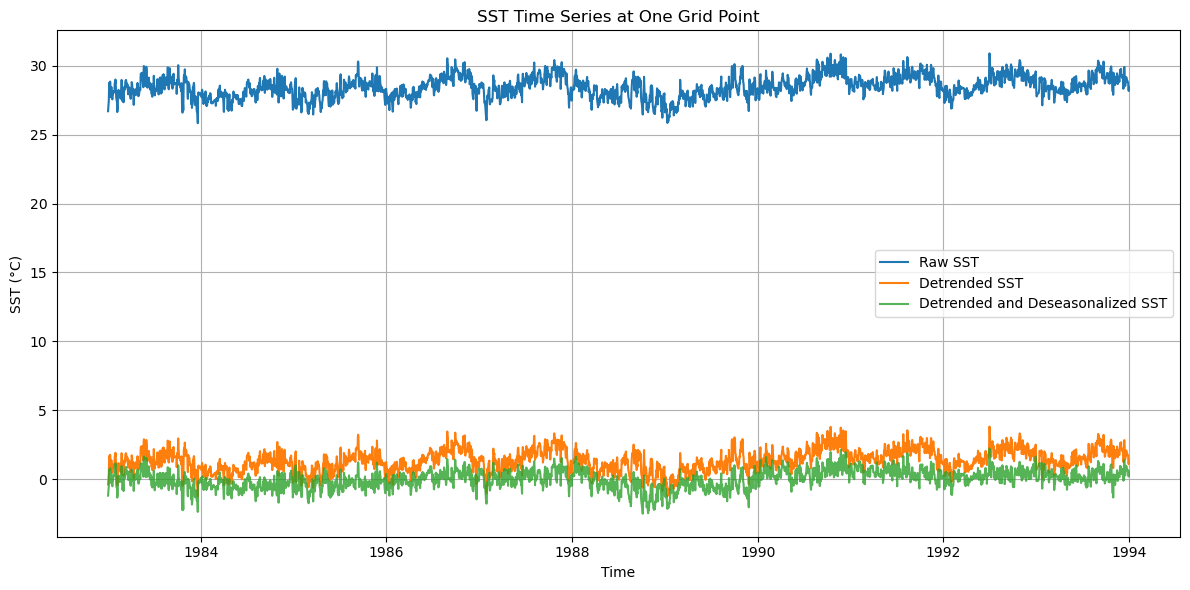

CPU times: user 60 s, sys: 1.82 s, total: 1min 1s
Wall time: 1min 27s


In [20]:
%%time
# Select one point via indices to keep things fast (center of subset)
lat_i = 20
lon_i = 20

# Extract 1-point time series (auto-convert to numpy by .compute())
raw_ts = sst_subset.isel(lat=lat_i, lon=lon_i).squeeze().compute()
detrended_ts = sst_detrended_subset.isel(lat=lat_i, lon=lon_i).squeeze().compute()
anom_ts = sst_anom_subset.isel(lat=lat_i, lon=lon_i).squeeze().compute()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(raw_ts['time'], raw_ts, label='Raw SST')
plt.plot(detrended_ts['time'], detrended_ts, label='Detrended SST')
plt.plot(anom_ts['time'], anom_ts, label='Detrended and Deseasonalized SST', alpha=0.8)
plt.legend()
plt.title("SST Time Series at One Grid Point")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot Mean & Std on Grid Using Subset

Using the grid subset defined above, plot the mean and standard deviation against lon, lat axes. 

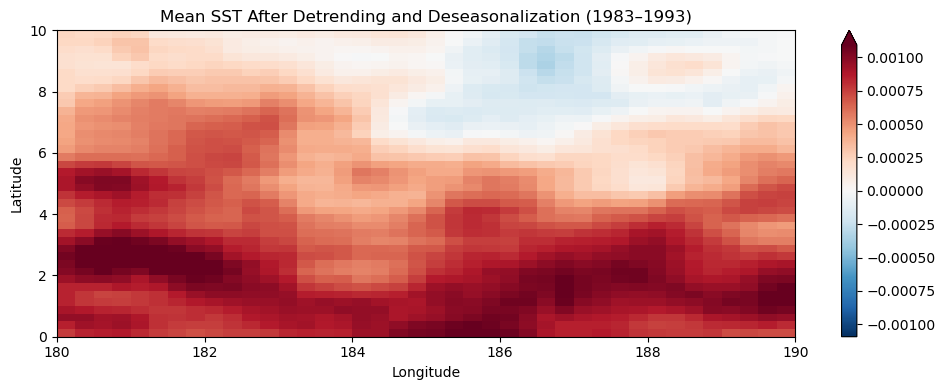

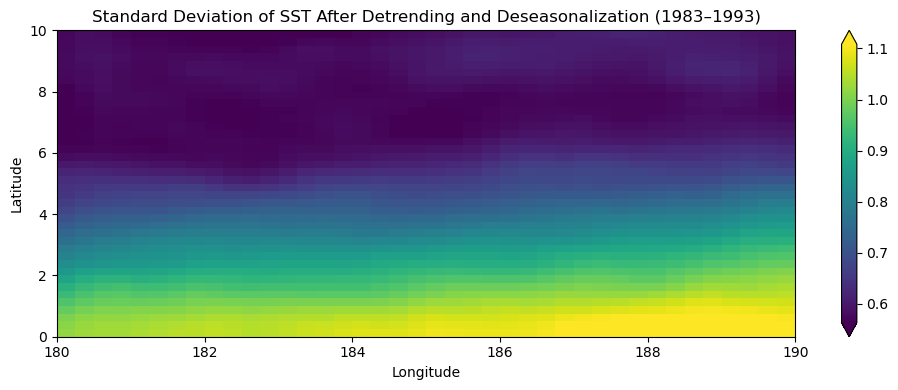

CPU times: user 1min 2s, sys: 1.57 s, total: 1min 3s
Wall time: 1min 25s


In [21]:
%%time

# Wall time: 1min 17s

# These return 2D arrays: (lat, lon)
anom_mean = sst_anom_subset.mean(dim='time')
anom_std = sst_anom_subset.std(dim='time')

# squeeze(): removes singleton dimensions; gives you a true 2D field
# mean_sst_surface = anom_mean.sel(zlev=anom_mean['zlev'][0]).squeeze()
# std_sst_surface = anom_std.sel(zlev=anom_std['zlev'][0]).squeeze()

# Mean SST after Detrending and Deseasonalization
plt.figure(figsize=(10, 4))
anom_mean.plot(cmap='RdBu_r', robust=True)
plt.title("Mean SST After Detrending and Deseasonalization (1983–1993)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# STD of SST after Detrending and Deseasonalization
plt.figure(figsize=(10, 4))
anom_std.plot(cmap='viridis', robust=True)
plt.title("Standard Deviation of SST After Detrending and Deseasonalization (1983–1993)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()